In [1]:
from sklearn.model_selection import LeaveOneOut
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

In [2]:
# part 1
# Epanechnikov kernel

def k(z):
    if np.abs(z)>=1:
        return 0
    return 3/4*(1-z**2)

assert k(5)  == 0
assert k(-2) == 0
assert k(.2) != 0

In [3]:
y_train = pd.read_csv("yTrain.csv", header=None)
y_test = pd.read_csv("yTest.csv", header=None)
protein_train = pd.read_csv("proteinTrain.csv", header=None)
protein_test = pd.read_csv("proteinTest.csv", header=None)
x = np.arange(70)
y = y_train.mean()

In [4]:
# reference: https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%201/Examples1.py
bandwidths = np.arange(1.1, 10, 0.1)
MSEs = []
for w in bandwidths:
    loo = LeaveOneOut()
    errs = []
    yhat=[]
    for trg, tst in loo.split(x):
        z = [k(v) for v in (x[tst]-x[trg])/w]
        yk = np.average(y[trg], weights=z)
        yhat.append(yk)
    mse = np.sum((yhat - y)**2)
    MSEs.append(mse)
MSEs = np.array(MSEs).squeeze()
w_star = bandwidths[np.argmin(MSEs)]

In [5]:
# optimal bandwidth
w_star

1.6000000000000005

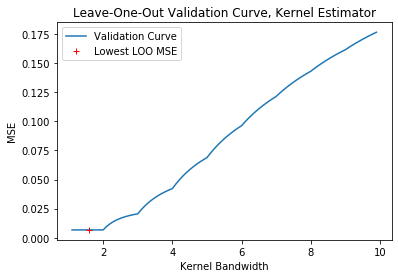

In [6]:
plt.plot(bandwidths, MSEs, label='Validation Curve')
plt.plot(w_star, min(MSEs),'r+', label='Lowest LOO MSE')
plt.title('Leave-One-Out Validation Curve, Kernel Estimator')
plt.xlabel('Kernel Bandwidth')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [7]:
yhat=[]
loo = LeaveOneOut()
for trg, tst in loo.split(x):
    z = [k(v) for v in (x[tst]-x[trg])/w_star]
    yk = np.average(y[trg], weights=z)
    yhat.append(yk)

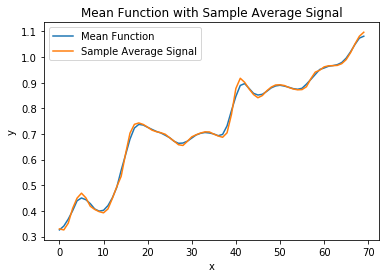

In [8]:
plt.plot(x, yhat, label='Mean Function')
plt.plot(x, y, label='Sample Average Signal')
plt.title('Mean Function with Sample Average Signal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [9]:
def smooth(y,w_star):
    yhat=[]
    loo = LeaveOneOut()
    for trg, tst in loo.split(x):
        z = [k(v) for v in (x[tst]-x[trg])/w_star]
        yk = np.average(y[trg], weights=z)
        yhat.append(yk)
    return yhat

In [10]:
# part 2
y_smooth = y_train.apply(lambda row: smooth(row,w_star), axis = 1)
y_smooth = pd.DataFrame(np.array([np.array(s) for s in y_smooth]))
reg = LinearRegression().fit(y_smooth, protein_train)
y_smooth_test = y_test.apply(lambda row: smooth(row,w_star), axis = 1)
y_smooth_test = pd.DataFrame(np.array([np.array(s) for s in y_smooth_test]))
y_hat_kernel = reg.predict(y_smooth_test)
np.sum((protein_test - y_hat_kernel)**2)

0    44.073991
dtype: float64

In [11]:
# part 3
# %% B-SPLINES
# reference: https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%201/Examples1.py
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.
    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

In [12]:
n = y.shape[0]
k=n
D = np.linspace(0, 1, n)
sigma = 0.3
knots = np.linspace(0, 1, k)
B = BSplineBasis(D, knots, 2)[:,:-2]

/home/jfftilton/anaconda3/envs/omsa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


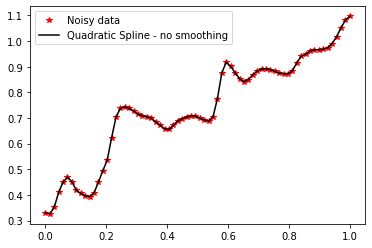

In [13]:
yhat = B@np.linalg.lstsq(B, y)[0]
assert np.isclose(B@np.linalg.inv(B.T@B)@B.T@y, yhat).all()
plt.plot(D, y, 'r*', label='Noisy data')
plt.plot(D, yhat, 'k-', label='Quadratic Spline - no smoothing')
plt.legend()
plt.show()

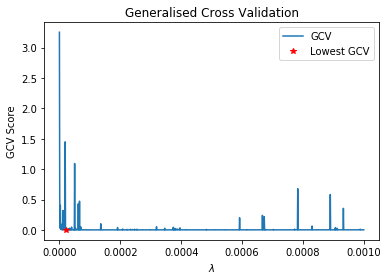

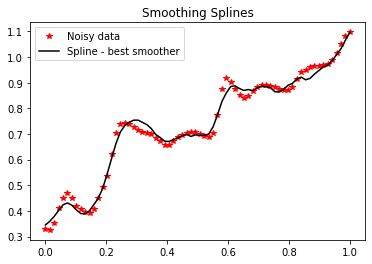

In [14]:
# reference: https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%201/Examples1.py
B2 = np.diff(B, axis=0, n=2)*(n-1)**2
omega = B2.T.dot(B2)/(n-2)
lams = np.arange(0, 1e-3, 1e-6)
p = len(lams)
RSS = []
df = []
for lam in lams:
    S = B@np.linalg.inv(B.T@B+lam*omega)@B.T  # Not great but we still need to get the trace of S
    yhat = S.dot(y)
    RSS.append(((yhat-y)**2).sum())
    df.append(np.trace(S))
RSS = np.array(RSS)
df = np.array(df)
# GCV criterion
GCV = (RSS/n)/(1-df/n)**2
i = np.argmin(GCV)
m = GCV[i]
plt.plot(lams, GCV, label='GCV')
plt.plot(lams[i], m, 'r*', label='Lowest GCV')
plt.title("Generalised Cross Validation")
plt.xlabel('$\lambda$')  # noqa: W605
plt.ylabel('GCV Score')
plt.legend()
plt.show()
S = B@np.linalg.inv(B.T@B+lams[i]*omega)@B.T
yhat = S@y
plt.plot(D, y, 'r*', label='Noisy data')
plt.plot(D, yhat, 'k-', label='Spline - best smoother')
plt.legend()
plt.title("Smoothing Splines")
plt.show()

In [15]:
# part 4
y_smooth = y_train.apply(lambda row: S@row, axis = 1)
y_smooth = pd.DataFrame(np.array([np.array(s) for s in y_smooth]))
reg = LinearRegression().fit(y_smooth, protein_train)
y_smooth_test = y_test.apply(lambda row: S@row, axis = 1)
y_smooth_test = pd.DataFrame(np.array([np.array(s) for s in y_smooth_test]))
y_hat_spline = reg.predict(y_smooth_test)
np.sum((protein_test - y_hat_spline)**2)

0    44.073991
dtype: float64

In [19]:
# part 5
df = pd.DataFrame({"spline":[x[0] for x in y_hat_spline], "kernel":[x[0] for x in y_hat_kernel]})
df

,spline,kernel
0,9.180781,9.180781
1,8.043734,8.043734
2,11.050827,11.050827
3,9.304310,9.304310
4,12.086602,12.086602
5,11.161356,11.161356
6,11.974393,11.974393
7,10.390906,10.390906
8,8.837624,8.837624
9,10.623142,10.623142


# Discussion
Unless I have done something wrong the predicted of the spline and kernel come out to be the same (44.1 mse).  Mind blown.

Although both methods come out to have the same answer, I recommend the kernel method only because it is much easier for me to comprehend, therefore explain, than b-splines.  